# Basics: Limb-darkened maps
In the previous tutorial, we talked about how to instantiate surface maps with arbitrary combinations of spherical harmonics. Here, we'll focus on a special case: the $m = 0$ spherical harmonics, which are all radially symmetric. As we show in [Luger & Agol (2018)](https://docs.google.com/viewer?url=https://github.com/rodluger/limbdark/raw/master-pdf/tex/limbdark.pdf), these form a complete basis to exactly describe arbitrary order polynomial limb-darkening in stars.

## The radial spherical harmonics

Here's what the first several radial spherical harmonics look like:

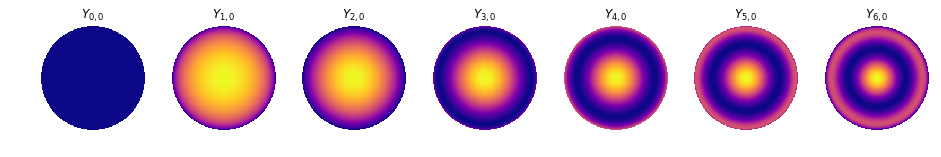

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

# Instantiate a `starry` surface map
lmax = 6
map = starry.Map(lmax)

res = 300
fig, ax = pl.subplots(1, lmax + 1, figsize=(16, 4))
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
for l in range(lmax + 1):
    map.reset()
    map[l, 0] = 1.0
    I = [map(x=x[j], y=y[j]) for j in range(res)]
    ax[l].imshow(I, origin="lower", interpolation="none", cmap='plasma', extent=(-1, 1, -1, 1))
    ax[l].axis('off')
    ax[l].set_title(r"$Y_{%d, 0}$" % l)
    ax[l].set_xlim(-1.05, 1.05)
    ax[l].set_ylim(-1.05, 1.05)

If we go out to infinite degree, we can express *any* radially symmetric function in terms of these harmonics. That makes this a very useful basis to model stellar limb darkening. In particular, consider the classic case of quadratic limb darkening, for which the specific intensity as a function of the radial coordinate $\mu$ (which is really just the Cartesian coordinate $z$) may be written

$\frac{I(\mu)}{I(1)} = 1 - u_1 (1 - \mu) - u_2 (1 - \mu)^2$

As we show in the paper, this can be written exactly as the sum of the first three radial spherical harmonics:

$\frac{I}{I(1)} =
            \frac{2\sqrt{\pi}}{3} (3 - 3u_1 - 4u_2) \, Y_{0,0}
          + \frac{2\sqrt{\pi}}{\sqrt{3}} (u_1 + 2u_2) \, Y_{1,0}
          - \frac{4\sqrt{\pi}}{3\sqrt{5}} u_2 \, Y_{2,0}$

For convenience, `starry.Map` allows users to directly specify limb darkening coefficients. Let's take a look.

## Limb-darkened maps

Let's instantiate a map as before, and let's peek at the `u` attribute, which is the vector of limb darkening coefficients:

In [2]:
map = starry.Map(2)
print(map.u)

[0. 0.]


By default, there's no limb darkening. The star's intensity is the same everywhere:

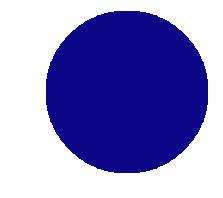

In [3]:
map.show()

One important thing to know is that the `Map` class is normalized such that the **average disk-integrated intensity is equal to the coefficient of the** $Y_{0,0}$ **spherical harmonic, which defaults to unity.**
This makes it very convenient to use the `Map` class to model stellar surfaces: regardless of the limb darkening coefficients, the total flux coming from the star measured by an observer will always be unity, since a purely limb-darkened object appears the same from all directions. We can check this by noting that the value anywhere on the surface is

In [4]:
map(x=0.3, y=-0.6)

0.31830988618379064

which, integrated over the unit disk is just

In [5]:
np.pi * map(x=0.3, y=-0.6)

0.9999999999999999

i.e., unity. You'll notice that a consequence of this is that the zeroth order limb-darkening coefficient $u_0$ **cannot** be set: its value is determined automatically to enforce this normalization.

Before we start playing around with this map, one last note: rotations do not affect the limb darkening coefficients. It wouldn't really make sense for the limb darkening profile to rotate around with the star -- for instance, you'd end up with negative surface brightness if you rotated it by 180 degrees! There are, of course, cases where you'd like to rotate a star (if it has spots, for instance, and you're interested in its rotational light curve). `starry` allows you to do that, too!

## Quadratic limb darkening

I remember reading somewhere that the Sun's quadratic limb darkening coefficients in the `Kepler` band are $u_1 = 0.40$ and $u_2 = 0.26$. Let's model that with `starry`:

In [6]:
map[1] = 0.4
map[2] = 0.26
print(map.u)

[0.4  0.26]


Note that, unlike spherical harmonic coefficients (which are indexed by two values, `l` and `m`), the limb darkening coefficients are specified by a **single** index `l` (since `m = 0` always). Here's what our map looks like:

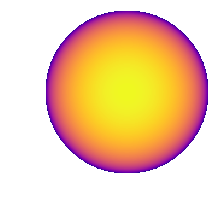

In [7]:
map.show()

We can verify, just for completeness, that we could have obtained the same exact map (up to a normalization constant) by setting the correct coefficients in the `Map` class:

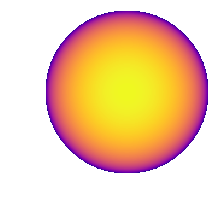

In [8]:
map2 = starry.Map(2)
u1 = 0.4
u2 = 0.26
map2[0, 0] = 2 * np.sqrt(np.pi) / 3 * (3 - 3 * u1 - 4 * u2)
map2[1, 0] = 2 * np.sqrt(np.pi) / np.sqrt(3) * (u1 + 2 * u2)
map2[2, 0] = -4 * np.sqrt(np.pi) / (3 * np.sqrt(5)) * u2
map2.show()

But that's harder, messier, and slower to evaluate. And, if you rotate the map, this hacky "limb darkening" will rotate, too, which is not good! Let's go back to our original limb-darkened map and compute some transit light curves.

## Transit light curves

These are super easy. Let's compute a simple transit light curve of a hot Jupiter:

In [9]:
xo = np.linspace(-2.5, 2.5, 1000)
yo = 0.3
ro = 0.1
flux = map.flux(xo=xo, yo=yo, ro=ro)

Here we're sliding the occultor along the $x$ direction from $x_o=-2.5$ to $x_o=2.5$ at $y_o = 0.3$. The occultor's radius in units of the stellar radius is $r_o = 0.3$. Let's plot the light curve:

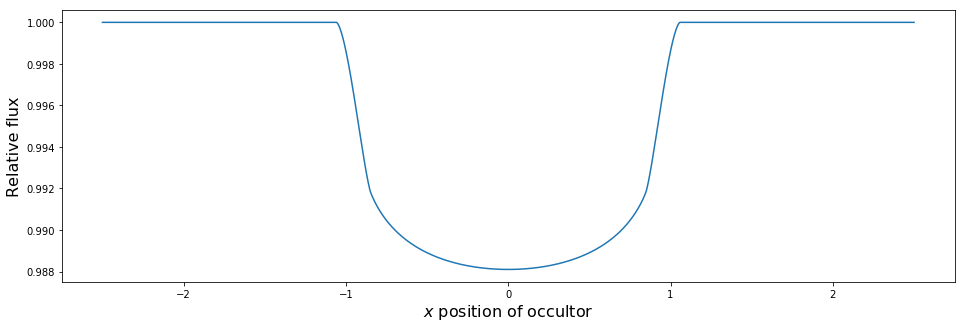

In [10]:
fig, ax = pl.subplots(1, figsize=(16, 5))
ax.plot(xo, flux)
ax.set_xlabel('$x$ position of occultor', fontsize=16);
ax.set_ylabel('Relative flux', fontsize=16);

Note that when instantiating a `Map` object, in order to compute light curves we must explicitly provide the trajectory of the occultor in Cartesian coordinates. That's great if you know how to compute the path of the occultor, but often it's more convenient to specify the actual orbital parameters of the system and let (say) a Keplerian solver compute the trajectories. That's what the `starry.kepler` module is for, and we discuss how to use it in the [Exoplanet systems](basics3.html) tutorial.

## [Advanced] Applying limb darkening to spherical harmonic maps

The limb-darkened map above is as simple as it gets: we took a disk of uniform surface intensity and we limb-darkened it to second order. But what if our star has some surface features (such as spots) and there's limb darkening on top of *that*?

It's actually straightforward to model that with `starry`. Let's begin by creating a `Map` object with a Gaussian star spot. We'll instantiate a map of fairly high degree to get a decent expansion of the Gaussian in spherical harmonics.

In [11]:
map = starry.Map(lmax=20)
map.add_gaussian(amp=-1.0, sigma=0.15, lat=30, lon=15, lmax=18)

The line above added (the expansion of) a Gaussian to the map with amplitude $-1.0$ (i.e., a dark spot) and standard deviation $0.1$ at a latitude of 30 degrees and a longitude of 15 degrees relative to the sub-observer point. Note that we instantiated a 20th degree map but limited the Gaussian expansion to 18th degree, since we plan on adding 2nd order limb darkening.

Instead of calling `map.show()`, let's write a few lines of code to add a colorbar to the image so we can see how dark the spot actually is:

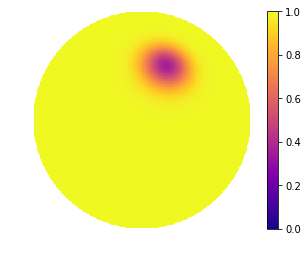

In [12]:
fig, ax = pl.subplots(1)
res = 300
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
I = [map(x=x[j], y=y[j]) for j in range(res)]
I /= np.nanmax(I)
im = ax.imshow(I, origin='lower', cmap='plasma', vmin=0, vmax=1)
pl.colorbar(im)
ax.axis('off');

Looks good! We have a spot at $(lat,\, lon) = (30^\circ, 15^\circ)$ that's fairly dark, with a peak intensity that's about 50% that of the rest of the star. 

**NOTE:** *If you squint (or change the color scale), you'll notice a "ringing" effect around the spot, due to our attempt to expand a Gaussian in terms of periodic functions. The smaller the spot, the more pronounced the ringing will be at a given spherical harmonic degree. It's probably not a good idea to use* `starry` *to model tiny spots, as you'd have to take the expansion up to pretty high degree and that will be pretty slow to evaluate.*

For fun, let's animate our star as it rotates:

In [65]:
map.animate()

We're going to add limb darkening in just a bit, but first let's compute the light curve of a planet transiting this spot with no limb darkening. We'll compare our final result to this.

In [76]:
xo = np.linspace(-2.5, 2.5, 1000)
yo = 0.3
ro = 0.1
flux = map.flux(xo=xo, yo=yo, ro=ro)

Here's what that light curve looks like:

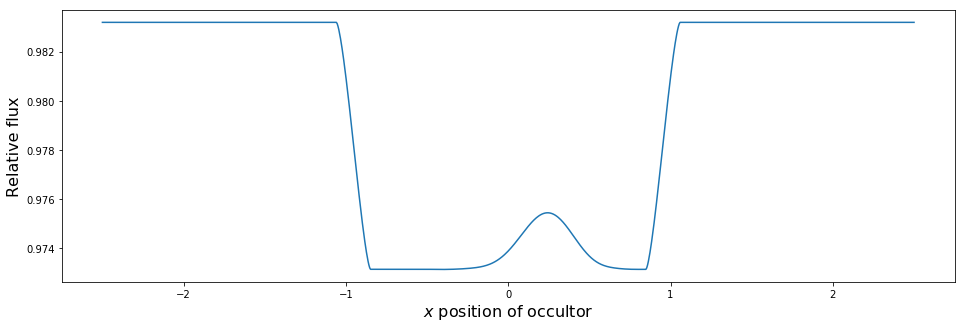

In [77]:
fig, ax = pl.subplots(1, figsize=(16, 5))
ax.plot(xo, flux)
ax.set_xlabel('$x$ position of occultor', fontsize=16);
ax.set_ylabel('Relative flux', fontsize=16);

It's quite pretty! The spot crossing is clearly visible.

OK, now let's limb darken the map and compare. We apply limb darkening just as before: by setting the limb darkening coefficients directly.

In [78]:
map[1] = 0.4
map[2] = 0.26

Here's what our star looks like now, on the same color scale as before:

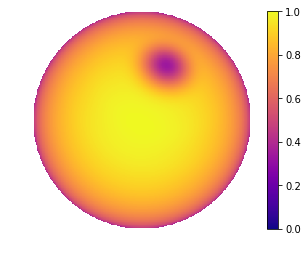

In [69]:
fig, ax = pl.subplots(1)
res = 300
x, y = np.meshgrid(np.linspace(-1, 1, res), np.linspace(-1, 1, res))
I = [map(x=x[j], y=y[j]) for j in range(res)]
I /= np.nanmax(I)
im = ax.imshow(I, origin='lower', cmap='plasma', vmin=0, vmax=1)
pl.colorbar(im)
ax.axis('off');

And again, just for fun, let's animate its rotation:

In [72]:
map.animate()

As promised, the limb darkening profile doesn't rotate: only the underlying star does!

Let's compute the *same transit light curve* as before:

In [79]:
xo = np.linspace(-2.5, 2.5, 1000)
yo = 0.3
ro = 0.1
flux_ld = map.flux(xo=xo, yo=yo, ro=ro)

Finally, let's plot the light curve, alongside the one with no limb darkening:

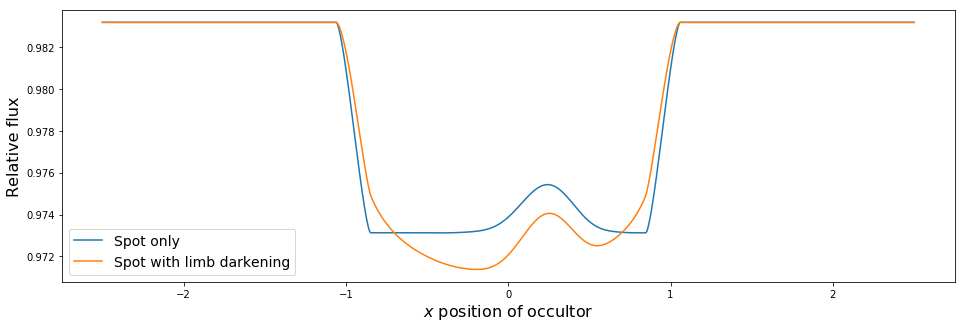

In [85]:
fig, ax = pl.subplots(1, figsize=(16, 5))
ax.plot(xo, flux, label='Spot only')
ax.plot(xo, flux_ld, label='Spot with limb darkening')
ax.set_xlabel('$x$ position of occultor', fontsize=16);
ax.set_ylabel('Relative flux', fontsize=16);
ax.legend(fontsize=14);

It's a beauty!